# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.785062,False,-1.236677
1,-1.574046,False,-1.917252
2,1.528382,True,5.802282
3,0.395196,True,6.070205
4,0.613484,True,5.988008
...,...,...,...
995,1.246889,True,3.999096
996,0.339738,True,5.404317
997,2.548132,True,8.077662
998,0.314423,True,4.519325


<Axes: xlabel='v0'>

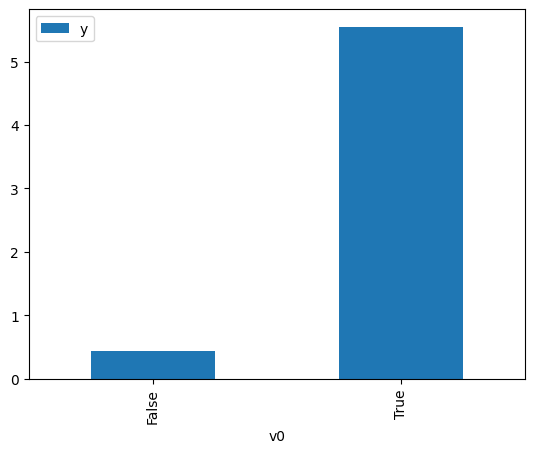

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

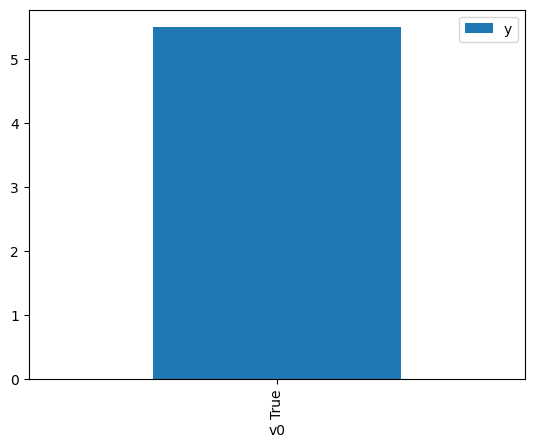

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.252717,False,1.747716,0.036419,27.458182
1,1.402296,False,1.225915,0.025504,39.209914
2,0.279380,False,0.800666,0.292352,3.420535
3,0.818901,False,-0.535488,0.098888,10.112431
4,0.961814,False,0.985590,0.071705,13.946063
...,...,...,...,...,...
995,-0.359420,False,-0.292875,0.664988,1.503786
996,-0.190684,False,-0.135580,0.567339,1.762614
997,0.853484,False,-0.373609,0.091570,10.920611
998,0.317222,False,1.237710,0.273494,3.656391


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.202116,True,4.203112,0.666888,1.499503
1,-0.748466,True,3.293356,0.162258,6.163039
2,-0.017074,True,5.148445,0.538815,1.855924
3,0.284791,True,6.081736,0.710391,1.407676
4,0.960532,True,5.546058,0.928085,1.077487
...,...,...,...,...,...
995,1.030747,True,5.791906,0.938783,1.065209
996,1.539835,True,6.798056,0.981676,1.018666
997,3.268864,True,8.304323,0.999733,1.000267
998,1.939459,True,7.374078,0.993056,1.006992


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.252e+04
Date:                Mon, 09 Jun 2025   Prob (F-statistic):                        0.00
Time:                        16:38:13   Log-Likelihood:                         -1401.7
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7650      0.038     20.122      0.000       0.690       0.840
x2             5.0256      0.053     94.569      0.000       4.921       5.130
==============================================================================
Omnibus:                        3.406   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                3.566
Skew:                           0.070   Prob(JB):                        0.168
Kurtosis:                       3.257   Cond. No.                         2.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""